Importujemy potrzebne biblioteki oraz ustawiamy ilość testów

In [38]:
#Zastosowane w piewszym i drugim modelu
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

num_of_experiments = 5

Wczytujemy dane z plików "horseColicTraining" oraz "horseColicTest" i zapisujemy je w zmiennych trainingSet, trainingLabels oraz testSet, testLabels. Tworzymy listy do przechowywania dokładności modeli.

In [39]:
# Funkcja wczytująca dane z pliku "file_name", zapisuje dane w zmiennych "data_set" (cechy) i "data_labels" (etykiety)
def load_data(file_name):
    data_set = []
    data_labels = []
    with open(file_name) as fr:
        for line in fr.readlines():
            curr_line = line.strip().split('\t') # Rozdzielamy dane na kolumny (dane oddzielone tabulatorem)
            line_arr = [float(curr_line[i]) for i in range(21)]  # Pierwsze 21 kolumn to cechy
            data_set.append(line_arr) # Dodajemy cechy do data_set
            data_labels.append(float(curr_line[21]))  # 22 kolumna to etykiety. Dodajemy etykiety do data_labels
    return np.array(data_set), np.array(data_labels)

# Wczytujemy zestawy danych treningowych i testowych
trainingSet, trainingLabels = load_data('horseColicTraining.txt')
testSet, testLabels = load_data('horseColicTest.txt')

accuracy_logreg = []
accuracy_log = []
accuracy_tree = []

Tworzymy funkcje do generowania także dane, aby przeprowadzić na nich testy. Tworzymy listy do przechowywania dokładności modeli.

In [40]:
def generate_synthetic_data(n_samples=500, n_features=5):
    X = np.random.rand(n_samples, n_features)
    y = np.random.randint(0, 2, size=n_samples) 
    return X, y

accuracy_logreg_synthetic = []
accuracy_log_synthetic = []
accuracy_tree_synthetic = []

Zaimplementowanie modelu regresji logistycznej na przykładzie podanym na https://github.com/pbharrin/machinelearninginaction

In [41]:
# Funkcja sigmoid — oblicza prawdopodobieństwo na podstawie funkcji logistycznej
def sigmoid(inX):
    return 1.0 / (1 + np.exp(-inX)) # Funkcja logistyczna, która zwraca wartości w przedziale (0, 1)

# Funkcja klasyfikująca wektor cech na podstawie wagi modelu
def classifyVector(inX, weights):
    prob = sigmoid(sum(inX * weights)) # Obliczamy prawdopodobieństwo
    return 1.0 if prob > 0.5 else 0.0 # Zwracamy 1.0 jeśli prawdopodobieństwo > 0.5, w przeciwnym razie 0.0

def LogRegress(dataMatrix, classLabels, numIter=150, learning_rate=0.001):
    m, n = np.shape(dataMatrix) # m — liczba próbek, n — liczba cech
    weights = np.ones(n)   #  Inicjalizujemy wagi na wartość 1
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m): # Dla każdej próbki
            alpha = learning_rate / (1.0 + j + i) + 0.0001
            randIndex = int(np.random.uniform(0, len(dataIndex)))  
            h = sigmoid(sum(dataMatrix[randIndex] * weights)) # Obliczamy prawdopodobieństwo przy użyciu funkcji sigmoid
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            del(dataIndex[randIndex])  # Usuwamy użyty indeks, by nie powtarzać tej samej próbki
    return weights

Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na "przetasowanych" danych HorseColic oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

In [42]:
# Funkcja do przeprowadzania wielu eksperymentów i zbierania predykcji
def MultiTestHorse(num_experiments):
    # Inicjalizacja list do przechowywania dokładności modeli
    accuracy_logreg = []  # Lista dla dokładności niestandardowej regresji logistycznej
    accuracy_log = []     # Lista dla dokładności regresji logistycznej z scikit-learn
    accuracy_tree = []    # Lista dla dokładności drzewa decyzyjnego

    # Listy do zbierania wszystkich predykcji z każdego eksperymentu
    all_predictions_logreg = []  # Lista dla predykcji niestandardowej regresji logistycznej
    all_predictions_log = []     # Lista dla predykcji regresji logistycznej z scikit-learn
    all_predictions_tree = []    # Lista dla predykcji drzewa decyzyjnego

    for i in range(num_experiments):
        # Tasowanie i dzielenie zbioru treningowego losowo w każdym eksperymencie
        indices = np.random.permutation(len(trainingSet))  # Losowe permutowanie indeksów zbioru treningowego
        shuffled_trainingSet = trainingSet[indices]        # Tasowany zbiór treningowy
        shuffled_trainingLabels = trainingLabels[indices]  # Tasowane etykiety treningowe

        # Trenowanie niestandardowego modelu regresji logistycznej
        trainWeights = LogRegress(shuffled_trainingSet, shuffled_trainingLabels, 1000, 0.01)  # Trening modelu z funkcją LogRegress
        predictions_logreg_probs = [classifyVector(sample, trainWeights) for sample in testSet]  # Obliczanie prawdopodobieństw dla zbioru testowego
        predictions_logreg = [1 if prob >= 0.5 else 0 for prob in predictions_logreg_probs]  # Konwersja prawdopodobieństw na klasy 0/1
        all_predictions_logreg.extend(predictions_logreg)  # Zbieranie predykcji
        acc_logreg = accuracy_score(testLabels, predictions_logreg)  # Obliczanie dokładności modelu
        accuracy_logreg.append(acc_logreg)  # Dodanie dokładności do listy

        # Trenowanie modelu regresji logistycznej z scikit-learn
        log_model = LogisticRegression(max_iter=5000)  # Definiowanie modelu regresji logistycznej
        log_model.fit(shuffled_trainingSet, shuffled_trainingLabels)  # Trening modelu na tasowanym zbiorze
        predictions_log_probs = log_model.predict_proba(testSet)[:, 1]  # Obliczanie prawdopodobieństw klas 1
        predictions_log = [1 if prob >= 0.5 else 0 for prob in predictions_log_probs]  # Konwersja prawdopodobieństw na klasy
        all_predictions_log.extend(predictions_log)  # Zbieranie predykcji
        acc_log = accuracy_score(testLabels, predictions_log)  # Obliczanie dokładności modelu
        accuracy_log.append(acc_log)  # Dodanie dokładności do listy

        # Trenowanie modelu drzewa decyzyjnego z scikit-learn
        tree_model = DecisionTreeClassifier()  # Definiowanie modelu drzewa decyzyjnego
        tree_model.fit(shuffled_trainingSet, shuffled_trainingLabels)  # Trening modelu na tasowanym zbiorze
        predictions_tree_probs = tree_model.predict_proba(testSet)[:, 1]  # Obliczanie prawdopodobieństw dla klasy 1
        predictions_tree = [1 if prob >= 0.5 else 0 for prob in predictions_tree_probs]  # Konwersja prawdopodobieństw na klasy
        all_predictions_tree.extend(predictions_tree)  # Zbieranie predykcji
        acc_tree = accuracy_score(testLabels, predictions_tree)  # Obliczanie dokładności modelu
        accuracy_tree.append(acc_tree)  # Dodanie dokładności do listy

    # Zwracanie wszystkich zebranych predykcji i dokładności modeli
    return all_predictions_logreg, all_predictions_log, all_predictions_tree, accuracy_tree, accuracy_log, accuracy_logreg


Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na wygenerowanych danych oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

In [ ]:
# Funkcja do przeprowadzania wielu eksperymentów na syntetycznych danych
def MultiTestSynth(num_experiments):
    # Listy do przechowywania dokładności
    accuracy_logreg_synthetic = []  # Lista dla dokładności niestandardowej regresji logistycznej na danych syntetycznych
    accuracy_log_synthetic = []     # Lista dla dokładności regresji logistycznej z scikit-learn na danych syntetycznych
    accuracy_tree_synthetic = []    # Lista dla dokładności drzewa decyzyjnego na danych syntetycznych 

    # Listy do zbierania wszystkich predykcji z każdego eksperymentu
    all_predictions_logreg_synthetic = []  # Predykcje niestandardowej regresji logistycznej na danych syntetycznych.
    all_predictions_log_synthetic = []     # Predykcje regresji logistycznej z scikit-learn na danych syntetycznych.
    all_predictions_tree_synthetic = []    # Predykcje drzewa decyzyjnego na danych syntetycznych.

    for i in range(num_experiments):
        # Generowanie syntetycznego zbioru danych
        synthetic_X, synthetic_y = generate_synthetic_data()  # Funkcja generująca dane syntetyczne
        
        # Podział danych syntetycznych na zbiór treningowy i testowy (80/20)
        split_index = int(0.8 * len(synthetic_X))  # Wyznaczanie indeksu podziału
        X_train, X_test = synthetic_X[:split_index], synthetic_X[split_index:]  # Dane treningowe i testowe
        y_train, y_test = synthetic_y[:split_index], synthetic_y[split_index:]  # Etykiety treningowe i testowe

        # Trenowanie niestandardowego modelu regresji logistycznej
        trainWeights = LogRegress(X_train, y_train, 1000, 0.01)  # Trening modelu
        predictions_logreg = [classifyVector(sample, trainWeights) for sample in X_test]  # Predykcje
        all_predictions_logreg_synthetic.extend(predictions_logreg)  # Zbieranie predykcji
        acc_logreg = accuracy_score(y_test, predictions_logreg)  # Obliczanie dokładności
        accuracy_logreg_synthetic.append(acc_logreg)  # Dodanie dokładności do listy

        # Trenowanie modelu regresji logistycznej z scikit-learn
        log_model = LogisticRegression(max_iter=2000)  # Zwiększona liczba iteracji dla zbieżności
        log_model.fit(X_train, y_train)  # Trening modelu
        predictions_log = log_model.predict(X_test)  # Predykcje
        all_predictions_log_synthetic.extend(predictions_log)  # Zbieranie predykcji
        acc_log = accuracy_score(y_test, predictions_log)  # Obliczanie dokładności
        accuracy_log_synthetic.append(acc_log)  # Dodanie dokładności do listy

        # Trenowanie modelu drzewa decyzyjnego
        tree_model = DecisionTreeClassifier()  # Definiowanie modelu drzewa decyzyjnego
        tree_model.fit(X_train, y_train)  # Trening modelu
        predictions_tree = tree_model.predict(X_test)  # Predykcje
        all_predictions_tree_synthetic.extend(predictions_tree)  # Zbieranie predykcji
        acc_tree = accuracy_score(y_test, predictions_tree)  # Obliczanie dokładności
        accuracy_tree_synthetic.append(acc_tree)  # Dodanie dokładności do listy

    # Zwracanie predykcji i prawdziwych etykiet do dalszego wykresowania
    return y_test, all_predictions_logreg_synthetic, all_predictions_log_synthetic, all_predictions_tree_synthetic, accuracy_logreg_synthetic, accuracy_log_synthetic, accuracy_tree_synthetic


Wyświetlanie wykresów Dokładności i Ground Truth dla danych HorseColic

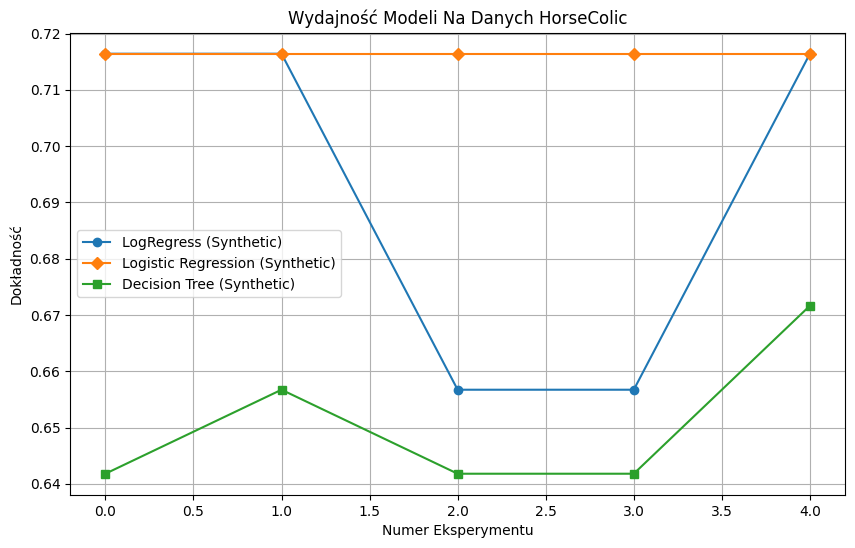


Średnia dokładność niestandardowej regresji logistycznej: 69.25%
Średnia dokładność regresji logistycznej (Scikit-Learn): 71.64%
Średnia dokładność klasyfikatora drzewa decyzyjnego: 65.07% 



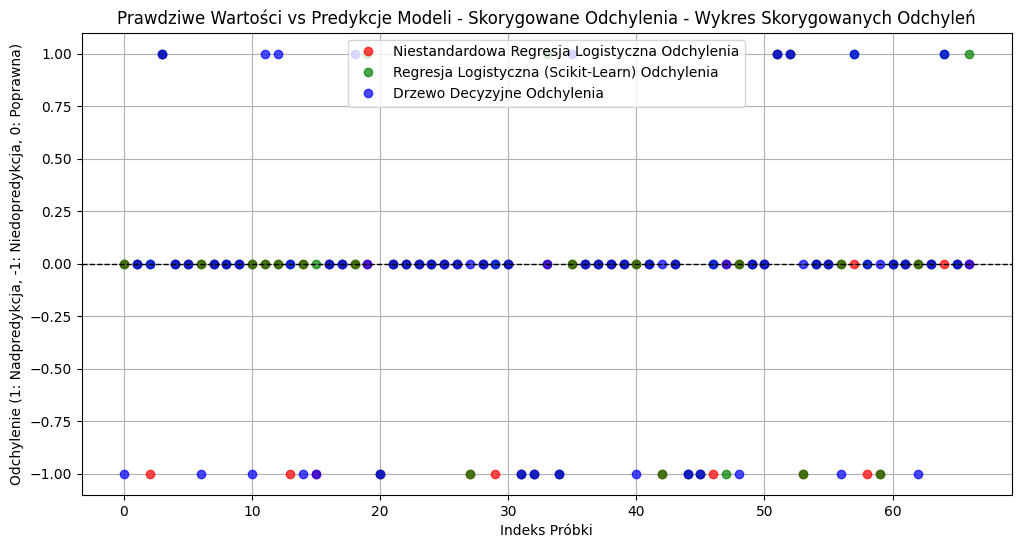

In [44]:
# Uruchamianie funkcji MultiTestHorse i zbieranie wyników
all_predictions_logreg, all_predictions_log, all_predictions_tree, accuracy_tree, accuracy_log, accuracy_logreg = MultiTestHorse(num_of_experiments)

# Tworzenie wykresu dla dokładności modeli w kolejnych eksperymentach
plt.figure(figsize=(10, 6))
plt.plot(range(num_of_experiments), accuracy_logreg, marker='o', label="LogRegress (Synthetic)")  # Wyniki dla niestandardowej regresji logistycznej
plt.plot(range(num_of_experiments), accuracy_log, marker='D', label="Logistic Regression (Synthetic)")  # Wyniki dla regresji logistycznej z scikit-learn
plt.plot(range(num_of_experiments), accuracy_tree, marker='s', label="Decision Tree (Synthetic)")  # Wyniki dla drzewa decyzyjnego
plt.xlabel("Numer Eksperymentu")  # Etykieta osi X
plt.ylabel("Dokładność")  # Etykieta osi Y
plt.title("Wydajność Modeli Na Danych HorseColic")  # Tytuł wykresu
plt.legend()  # Legenda opisująca modele
plt.grid(True)  # Dodanie siatki na wykresie
plt.show()  # Wyświetlenie wykresu

# Wypisywanie średnich dokładności dla każdego modelu
print("\nŚrednia dokładność niestandardowej regresji logistycznej: {:.2f}%".format(np.mean(accuracy_logreg) * 100))
print("Średnia dokładność regresji logistycznej (Scikit-Learn): {:.2f}%".format(np.mean(accuracy_log) * 100))
print("Średnia dokładność klasyfikatora drzewa decyzyjnego: {:.2f}% \n".format(np.mean(accuracy_tree) * 100))

# Definicja funkcji obliczającej i wykresującej odchylenia
true_labels = testLabels  # Zamień na prawdziwe etykiety (ground truth)
all_predictions = [all_predictions_logreg, all_predictions_log, all_predictions_tree]  # Zamień na swoje predykcje
labels = ["Niestandardowa Regresja Logistyczna", "Regresja Logistyczna (Scikit-Learn)", "Drzewo Decyzyjne"]
title = "Prawdziwe Wartości vs Predykcje Modeli - Skorygowane Odchylenia"

# Tworzenie wykresu odchyleń dla wszystkich modeli
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']  # Kolory dla każdego modelu

for predictions, label, color in zip(all_predictions, labels, colors):
    # Obliczanie odchyleń: 1 dla nadmiernej predykcji, -1 dla niedostatecznej, 0 dla poprawnych
    deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, predictions)]
    plt.plot(deviations, marker='o', linestyle='', label=f'{label} Odchylenia', alpha=0.7, color=color)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Linia bazowa dla braku odchylenia
plt.title(f'{title} - Wykres Skorygowanych Odchyleń')
plt.xlabel('Indeks Próbki')  # Etykieta osi X
plt.ylabel('Odchylenie (1: Nadpredykcja, -1: Niedopredykcja, 0: Poprawna)')  # Etykieta osi Y
plt.legend()  # Legenda opisująca modele i odchylenia
plt.grid(True)  # Dodanie siatki na wykresie
plt.show()  # Wyświetlenie wykresu


Uczenie modeli LogRegress, LogisticRegression (Scikit-learn) i DecisionTreeClassifier (Scikit-learn) na wygenerowanych danych oraz wyświetlanie wykresu Ground Truth po przeprowadzeniu podanej ilości testów.

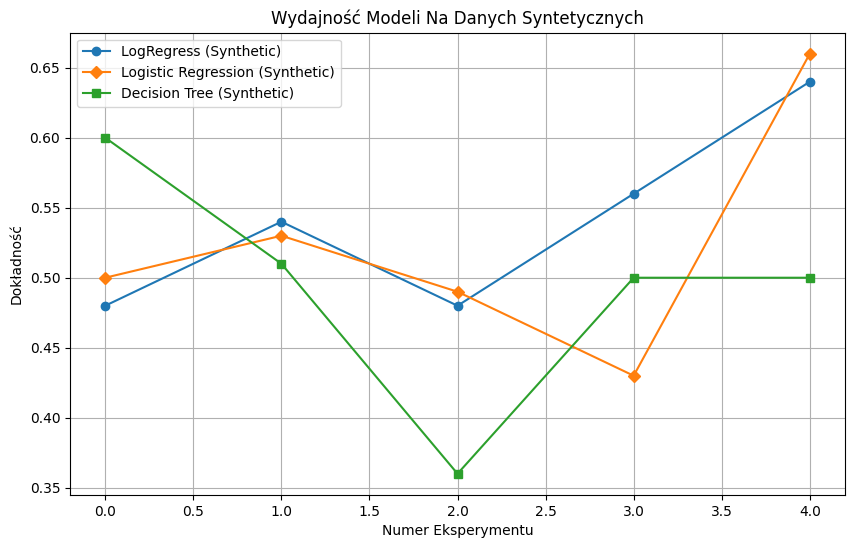


Średnia dokładność na danych syntetycznych - Niestandardowa Regresja Logistyczna: 54.00%
Średnia dokładność na danych syntetycznych - Regresja Logistyczna (Scikit-Learn): 52.20%
Średnia dokładność na danych syntetycznych - Drzewo Decyzyjne (Scikit-Learn): 49.40% 



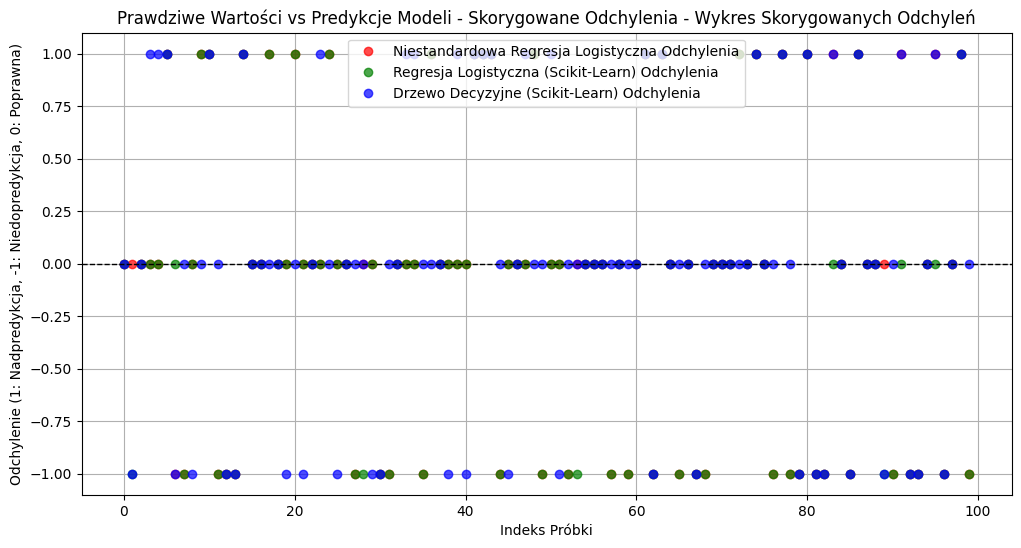

In [45]:
# Uruchamianie funkcji MultiTestSynth i zbieranie wyników na danych syntetycznych
y_test, all_predictions_logreg_synthetic, all_predictions_log_synthetic, all_predictions_tree_synthetic, accuracy_logreg_synthetic, accuracy_log_synthetic, accuracy_tree_synthetic = MultiTestSynth(num_of_experiments)

# Tworzenie wykresu dla dokładności modeli w kolejnych eksperymentach na danych syntetycznych
plt.figure(figsize=(10, 6))
plt.plot(range(num_of_experiments), accuracy_logreg_synthetic, marker='o', label="LogRegress (Synthetic)")  # Niestandardowa regresja logistyczna
plt.plot(range(num_of_experiments), accuracy_log_synthetic, marker='D', label="Logistic Regression (Synthetic)")  # Regresja logistyczna (scikit-learn)
plt.plot(range(num_of_experiments), accuracy_tree_synthetic, marker='s', label="Decision Tree (Synthetic)")  # Drzewo decyzyjne (scikit-learn)
plt.xlabel("Numer Eksperymentu")  # Oś X
plt.ylabel("Dokładność")  # Oś Y
plt.title("Wydajność Modeli Na Danych Syntetycznych")  # Tytuł wykresu
plt.legend()  # Legenda
plt.grid(True)  # Siatka na wykresie
plt.show()  # Wyświetlenie wykresu

# Wyświetlenie średnich dokładności na danych syntetycznych
print("\nŚrednia dokładność na danych syntetycznych - Niestandardowa Regresja Logistyczna: {:.2f}%".format(np.mean(accuracy_logreg_synthetic) * 100))
print("Średnia dokładność na danych syntetycznych - Regresja Logistyczna (Scikit-Learn): {:.2f}%".format(np.mean(accuracy_log_synthetic) * 100))
print("Średnia dokładność na danych syntetycznych - Drzewo Decyzyjne (Scikit-Learn): {:.2f}% \n".format(np.mean(accuracy_tree_synthetic) * 100))

# Prawdziwe etykiety
true_labels = y_test  # Zastąp rzeczywistymi etykietami (ground truth)
all_predictions = [all_predictions_logreg_synthetic, all_predictions_log_synthetic, all_predictions_tree_synthetic]  # Predykcje modeli
labels = ["Niestandardowa Regresja Logistyczna", "Regresja Logistyczna (Scikit-Learn)", "Drzewo Decyzyjne (Scikit-Learn)"]
title = "Prawdziwe Wartości vs Predykcje Modeli - Skorygowane Odchylenia"

# Tworzenie wykresu skorygowanych odchyleń
plt.figure(figsize=(12, 6))
colors = ['red', 'green', 'blue']  # Kolory dla każdego modelu

for predictions, label, color in zip(all_predictions, labels, colors):
    # Obliczanie odchyleń: 1 dla nadpredykcji, -1 dla niedopredykcji, 0 dla poprawnych
    deviations = [1 if pred > true else -1 if pred < true else 0 for true, pred in zip(true_labels, predictions)]
    plt.plot(deviations, marker='o', linestyle='', label=f'{label} Odchylenia', alpha=0.7, color=color)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # Linia bazowa dla braku odchylenia
plt.title(f'{title} - Wykres Skorygowanych Odchyleń')
plt.xlabel('Indeks Próbki')  # Etykieta osi X
plt.ylabel('Odchylenie (1: Nadpredykcja, -1: Niedopredykcja, 0: Poprawna)')  # Etykieta osi Y
plt.legend()  # Legenda
plt.grid(True)  # Siatka na wykresie
plt.show()  # Wyświetlenie wykresu
